# Are Six Models Better Than One?

The Titanic Mega Model is an ensemble of Kaggle's top 6 Titanic models and scores an impressive 84.2%!! First we will begin with my simple [Titanic using Name only model][10]. By carefully incorporating Ticket, Fare, and Pclass, we will raise its score to 83.3%. My model predicts survival for every boy in a family where all females and boys live. And it predicts perish for every female in a family where all females and boys died. It only makes 22 predictions. There are 396 passengers remaining in the test dataset. We will build an ensemble of Kaggle's top Titanic models to predict those.

![tree5](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/2020/tree6.jpeg)  

Models included are:  
* [Chris Deotte][9] - [Titanic using Name only [0.81818]][10] - scores 83.3%
* [Konstantin Masich][1] - [Titanic [0.82] - [0.83] ][2]- scores 83.3%
* [Shao-Chuan Wang][3] - [Titanic: ML tutorial on small dataset - [0.82296]][4] - scores 82.8%
* [Tae Hyon Whang][5] - [Titanic Starter with XGBoost, 173/209 LB][6] - scores 82.8%
* [Franck Sylla][7] - [Titanic: Machine Learning from Disaster][8] - scores 82.8%
* [Oscar Takeshita][11] - [Divide and Conquer [0.82296]][12] - scores 82.3%  

(To view a list of more Titanic models including non conventional ones, see Oscar Takeshita's [post here][13])

[1]:https://www.kaggle.com/konstantinmasich
[2]:https://www.kaggle.com/konstantinmasich/titanic-0-82-0-83/
[3]:https://www.kaggle.com/shaochuanwang
[4]:https://www.kaggle.com/shaochuanwang/titanic-ml-tutorial-on-small-dataset-0-82296/notebook
[5]:https://www.kaggle.com/numbersareuseful
[6]:https://www.kaggle.com/numbersareuseful/titanic-starter-with-xgboost-173-209-lb/notebook
[7]:https://www.kaggle.com/francksylla
[8]:https://www.kaggle.com/francksylla/titanic-machine-learning-from-disaster
[9]:https://www.kaggle.com/cdeotte
[10]:https://www.kaggle.com/cdeotte/titanic-using-name-only-0-81818/notebook
[11]:https://www.kaggle.com/pliptor
[12]:https://www.kaggle.com/pliptor/divide-and-conquer-0-82296/notebook
[13]:https://www.kaggle.com/pliptor/how-am-i-doing-with-my-score

# PART A: The Woman-Child-Group Model
In the Woman-Child-Group model posted [here][1], woman-child-groups were formed from surname. But, surname doesn't always imply that passengers are in the same family and traveling together. Look at passengers 195 and 1167:  
`PId Pclass              Name     Sex Age SibSp Parch   Ticket    Fare Cabin Embarked
195   1     Brown, Mrs. James  female  44     0     0 PC 17610 27.7208    B4        C
1067  2    Brown, Miss. Edith  female  15     0     2    29750 39.0000              S`  

They both have surname 'Brown' and appear to be a mother traveling with her daughter. However, they have different Pclasses, different Tickets, different Fares, different Cabins, different Embarked, and incompatible SibSp and Parch. I believe these two passengers are not related. Now look at passengers 59, 473 and 1142:  
`PId Pclass                 Name    Sex   Age SibSp Parch     Ticket  Fare Cabin Embarked
59      2 West, Miss. Constance  female  5.00     1     2 C.A. 34651 27.75              S
473     2 West, Mrs. Edwy Arthur female 33.00     1     2 C.A. 34651 27.75              S 
1142    2    West, Miss. Barbara female  0.92     1     2 C.A. 34651 27.75              S`  

They all have the surname 'West' and appear to be a mother traveling with her two daughters. They have the same Pclass, same Ticket, same Fare, same Cabin, same Embarked, and compatible SibSp and Parch. I believe these three passengers are related.

[1]:https://www.kaggle.com/cdeotte/titanic-using-name-only-0-81818

## A1. Engineer a precise GroupId for woman-child-groups
Let's engineer a GroupId that precisely identifies families. [Jack Roberts][3] demonstrated that Tickets contain the same grouping information as Surnames in his kernel [here][4]. Using only Ticket or only Surname to form groups leads to mistakes. So for each passenger, let's form the concatenation GroupId = Surname + Pclass + Ticket + Fare + Embarked. Sometimes tickets of passengers traveling together differ in their last digit, so let's also remove the last digit of the Ticket. For example, let's change Mrs West's Ticket from 'C.A. 34651' to 'C.A. 3465X'. (I learned this cool trick to remove ticket digits in section 4.2.4 of [Erik Bruin's][2] notebook [here][1]). I purposely do not include SibSp and Parch in our GroupId because they contain many errors (as explained below). And I do not include Cabin because too much Cabin data is missing.

[1]:https://www.kaggle.com/erikbruin/titanic-2nd-degree-families-and-majority-voting/notebook
[2]:https://www.kaggle.com/erikbruin
[3]:https://www.kaggle.com/jack89roberts
[4]:https://www.kaggle.com/jack89roberts/titanic-using-ticket-groupings

In [1]:
train <- read.csv('../input/titanic/train.csv',stringsAsFactors=F)
test <- read.csv('../input/titanic/test.csv',stringsAsFactors=F)
test$Survived <- NA; data <- rbind(train,test)
data$Surname = substring( data$Name,0,regexpr(',',data$Name)-1)
data$GroupId = paste( data$Surname, data$Pclass, sub('.$','X',data$Ticket), data$Fare, data$Embarked, sep='-')
data[c(195,1067,59,473,1142),c('Name','GroupId')]

,Name,GroupId
195,"Brown, Mrs. James Joseph (Margaret Tobin)",Brown-1-PC 1761X-27.7208-C
1067,"Brown, Miss. Edith Eileen",Brown-2-2975X-39-S
59,"West, Miss. Constance Mirium",West-2-C.A. 3465X-27.75-S
473,"West, Mrs. Edwy Arthur (Ada Mary Worth)",West-2-C.A. 3465X-27.75-S
1142,"West, Miss. Barbara J",West-2-C.A. 3465X-27.75-S


Using this new GroupId, it is clear that the Wests traveled together but the Browns did not. 

## A2. Identify Nannies and Relatives traveling in woman-child-groups.
Now look at the following passengers:  
`PId Pclass                      Name    Sex Age SibSp Parch   Ticket   Fare      Cabin Embarked
312   1    Ryerson, Miss. Emily Borie female  18     2    2 PC 17608 262.375 B57 B59 B63 B66   C
743   1  Ryerson, Miss. Susan Parker  female  21     2    2 PC 17608 262.375 B57 B59 B63 B66   C
91    1  Ryerson, Mrs. Maria          female  48     1    3 PC 17608 262.375 B57 B59 B63 B66   C
951   1   Chaudanson, Miss. Victorine female  36     0    0 PC 17608 262.375             B61   C
956   1   Ryerson, Master. John Borie   male  13     2    2 PC 17608 262.375 B57 B59 B63 B66   C
1034  1    Ryerson, Mr. Arthur Larned   male  61     1    3 PC 17608 262.375 B57 B59 B63 B66   C`  

This is the Ryerson family. There are two adults and three children. They stayed in Cabins B57, B59, B63, and B66 on Ticket = 'PC 17608' traveling Pclass=1 to Embarked=C. Notice that Miss. Chaudanson also bought a Ticket = 'PC 17608' and stayed in the cabin next to them, Cabin = B61. I assume that Miss. Chaudanson traveled with the Ryerson family and was either a nanny or a relative. We would like to add nannies and relatives to our woman-child-groups because the data shows that they lived or died with the woman and children they traveled with.

In [2]:
# engineer titles
data$Title <- 'man'
data$Title[data$Sex=='female'] <- 'woman'
data$Title[grep('Master',data$Name)] <- 'boy'
# color variable is used in plots below
data$Color <- data$Survived
# engineer "woman-child-groups"
data$GroupId[data$Title=='man'] <- 'noGroup'
data$GroupFreq <- ave(1:1309,data$GroupId,FUN=length)
data$GroupId[data$GroupFreq<=1] <- 'noGroup'
data$TicketId = paste( data$Pclass,sub('.$','X',data$Ticket),data$Fare,data$Embarked,sep='-')
count = 0
# add nannies and relatives to groups
for (i in which(data$Title!='man' & data$GroupId=='noGroup')){
    data$GroupId[i] = data$GroupId[data$TicketId==data$TicketId[i]][1]
    if (data$GroupId[i]!='noGroup') {
        # color variable is used in plots below
        if (is.na(data$Survived[i])) data$Color[i] = 5
        else if (data$Survived[i] == 0) data$Color[i] = -1
        else if (data$Survived[i] == 1) data$Color[i] = 2
        count = count + 1
    }
}
cat(sprintf('We found %d nannies/relatives and added them to groups.\n',count))

We found 9 nannies/relatives and added them to groups.


## A3. Classify unknown woman-child-groups
Let's display all the woman-child-groups

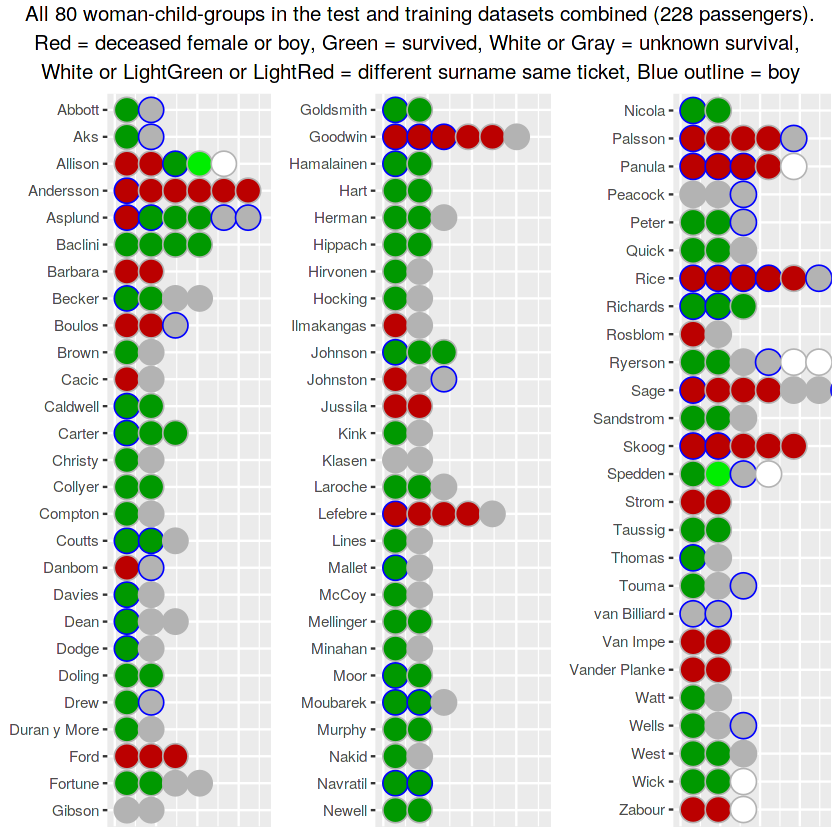

In [3]:
library(ggplot2)
library(gridExtra)
data$GroupName = substring( data$GroupId,0,regexpr('-',data$GroupId)-1)
data$Color[is.na(data$Color) & data$Title=='woman'] <- 3
data$Color[is.na(data$Color) & data$Title=='boy'] <- 4
x = data$GroupId[data$GroupId!='noGroup']; x = unique(x); x=x[order(x)]
plotData <- list(); g <- list()
for (i in 1:3) plotData[[i]] <- data[data$GroupId %in% x[(27*(i-1))+1:27],]
for (i in 1:3) g[[i]] = ggplot(data=plotData[[i]], aes(x=0,y=factor(GroupName))) +
    geom_dotplot(dotsize=0.9,binwidth=1,binaxis='y',method="histodot",stackgroups=T,
        aes(fill=factor(Color),color=Title )) +
    scale_color_manual(values=c('gray70','blue','gray70'),limits=c('man','boy','woman')) +
    scale_fill_manual(values=c('#BB0000','#FF0000','#009900','#00EE00','gray70','gray70','white'),
        limits=c('0','-1','1','2','3','4','5')) +
    scale_y_discrete(limits = rev(levels(factor(plotData[[i]]$GroupName)))) +
        theme(axis.title.x=element_blank(), axis.title.y=element_blank(),
        axis.text.x=element_blank(), axis.ticks.x=element_blank(),
        legend.position='none')
grid.arrange(g[[1]],g[[2]],g[[3]],nrow=1,top='All 80 woman-child-groups in the test and training datasets combined (228 passengers).
Red = deceased female or boy, Green = survived, White or Gray = unknown survival, 
White or LightGreen or LightRed = different surname same ticket, Blue outline = boy')

First notice how nearly all of the 80 woman-child-groups either all lived or all died (based on the survival information we know). That is the secret behind the woman-child-group model. It says that you should predict each unknown gray or white circle by setting it equal to the color of the dots preceding it. For example, Abbott shows one survived female traveling with one unknown boy. We should predict that the unknown boy, passenger 1284 Master Eugene Abbott, survived. There are four families whose entire group is unknown. These families are Gibson, Klasen, Peacock, van Billiard. We need to make predictions for them so let's explore which woman-child-groups live or die.

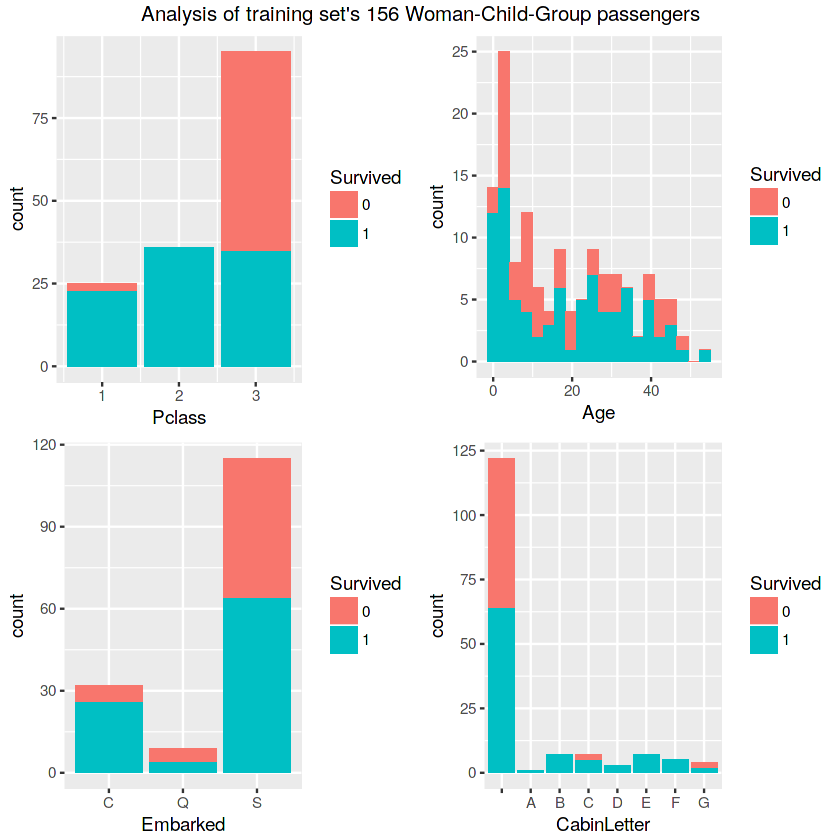

In [4]:
data$Survived <- factor(data$Survived)
data$CabinLetter <- substring(data$Cabin,0,1)
g1 = ggplot(data=data[data$GroupId!='noGroup' & !is.na(data$Survived),]) +
    geom_bar(stat='count',aes(x=Pclass,fill=Survived))
g2 = ggplot(data=data[data$GroupId!='noGroup' & !is.na(data$Survived) & !is.na(data$Age),]) +
    geom_histogram(bins=20,aes(x=Age,fill=Survived))
g3 = ggplot(data=data[data$GroupId!='noGroup' & !is.na(data$Survived),]) +
    geom_bar(stat='count',aes(x=Embarked,fill=Survived))
g4 = ggplot(data=data[data$GroupId!='noGroup' & !is.na(data$Survived),]) +
    geom_bar(stat='count',aes(x=CabinLetter,fill=Survived))
grid.arrange(g1,g2,g3,g4,nrow=2,top='Analysis of training set\'s 156 Woman-Child-Group passengers')

From this analysis, we see that woman-child-groups traveling in Pclass=1 or 2 mostly survived and woman-child-groups in Pclass=3 mostly died. The Gibsons had Pclass=1, Embarked=C, and no Cabin, therefore we should predict that the Gibsons survived. The Klasen's, Peacock's, and van Billiards had Pclass=3, Embarked=S, and no Cabin. Therefore we should predict that those three families perished.

## A4. Cross Validation
When using Name only, it was shown [here][1] that this model cross validates at 83.6% on the training dataset. Let's see if (1) using a precise GroupId, (2) including nannies and relatives, and (3) classifying unknown groups improves our model's accuracy.

[1]:https://www.kaggle.com/cdeotte/titanic-using-name-only-0-81818

In [5]:
# engineer titles on training set
train$Title <- 'man'
train$Title[train$Sex=='female'] <- 'woman'
train$Title[grep('Master',train$Name)] <- 'boy'
# Perform 25 trials of 10-fold cross validation
trials = 25; sum = 0
for (j in 1:trials){
x = sample(1:890); s = 0
for (i in 0:9){
    # engineer "woman-child-groups"
    train$Surname <- substring(train$Name,0,regexpr(",",train$Name)-1)
    train$GroupId = paste( train$Surname, train$Pclass,sub('.$','X',train$Ticket),train$Fare,train$Embarked,sep='-')
    train$GroupId[train$Title=='man'] <- 'noGroup'
    train$GroupFreq <- ave(1:891,train$GroupId,FUN=length)
    train$GroupId[train$GroupFreq<=1] <- 'noGroup'
    # add nannies and relatives to groups.
    train$TicketId = paste( train$Pclass,sub('.$','X',train$Ticket),train$Fare,train$Embarked,sep='-')
    for (k in which(train$Title!='man' & train$GroupId=='noGroup'))
        train$GroupId[k] = train$GroupId[train$TicketId==train$TicketId[k] & train$PassengerId != train$PassengerId[k]][1]
    train$GroupId[is.na(train$GroupId)] <- 'noGroup'
    train$GroupFreq <- ave(1:891,train$GroupId,FUN=length)
    # calculate training subset's group survival rate
    train$GroupSurvival <- NA
    train$GroupSurvival[-x[1:89+i*89]] <- ave(train$Survived[-x[1:89+i*89]],train$GroupId[-x[1:89+i*89]])
    # calculate testing subset's group survival rate from training set's rate
    for (k in x[1:89+i*89]){ 
        train$GroupSurvival[k] <- train$GroupSurvival[which(!is.na(train$GroupSurvival) & train$GroupId==train$GroupId[k])[1]]
        if (is.na(train$GroupSurvival[k])) train$GroupSurvival[k] <- ifelse(train$Pclass[k]==3,0,1)
    }
    # apply gender model plus WCG
    train$predict <- 0
    train$predict[train$Title=='woman'] <- 1
    train$predict[train$Title=='boy' & train$GroupSurvival==1] <- 1
    train$predict[train$Title=='woman' & train$GroupSurvival==0] <- 0
    c = sum(abs(train$predict[x[1:89+i*89]] - train$Survived[x[1:89+i*89]]))
    s = s + c
}
#cat( sprintf("Trial %d has 10-fold CV accuracy = %f\n",j,1-s/890))
sum = sum + 1-s/890
}
cat(sprintf("Average 10-fold CV accuracy from %d trials = %f\n",trials,sum/trials))

Average 10-fold CV accuracy from 25 trials = 0.844539


Great, our accuracy increased by 0.8% to 84.4%. It looks like our changes helped. Let's make predictions on the test dataset and submit them to Kaggle.

## A5. Make Predictions
There are 72 passengers that are part of woman-child-groups in the test dataset. Let's apply our two prediction rules:  
1. If an unknown passenger's woman-child-group all lived or all died (as indicated by the training dataset), predict that they did the same.
2. If an unknown passenger's woman-child-group has no members in the training dataset, use Pclass to predict their survival with Pclass=3 die, Pclass=1 or 2 live.

In [6]:
data$GroupSurvival <- NA
data$Survived <- as.numeric(as.character(data$Survived))
data$GroupSurvival[1:891] <- ave(data$Survived[1:891],data$GroupId[1:891])
for (i in 892:1309) data$GroupSurvival[i] <- data$GroupSurvival[which(data$GroupId==data$GroupId[i])[1]]
data$GroupSurvival[is.na(data$GroupSurvival) & data$Pclass==3] <- 0
data$GroupSurvival[is.na(data$GroupSurvival) & data$Pclass!=3] <- 1
data$Predict <- 0
data$Predict[data$Sex=='female'] <- 1
data$Predict[data$Title=='woman' & data$GroupSurvival==0] <- 0
data$Predict[data$Title=='boy' & data$GroupSurvival==1] <- 1

In [7]:
cat('The following 8 males are predicted to live\n')
data[data$Sex=='male' & data$Predict==1 & data$PassengerId>891,c('Name','Title')]
cat('The following 14 females are predicted to die\n')
data[data$Sex=='female' & data$Predict==0 & data$PassengerId>891,c('Name','Title')]
cat('The remaining 258 males are predicted to die\n')
cat('and the remaining 138 females are predicted to live\n')

The following 8 males are predicted to live


,Name,Title
956,"Ryerson, Master. John Borie",boy
981,"Wells, Master. Ralph Lester",boy
1053,"Touma, Master. Georges Youssef",boy
1086,"Drew, Master. Marshall Brines",boy
1088,"Spedden, Master. Robert Douglas",boy
1199,"Aks, Master. Philip Frank",boy
1284,"Abbott, Master. Eugene Joseph",boy
1309,"Peter, Master. Michael J",boy


The following 14 females are predicted to die


,Name,Title
910,"Ilmakangas, Miss. Ida Livija",woman
925,"Johnston, Mrs. Andrew G (Elizabeth Lily"" Watson)""",woman
929,"Cacic, Miss. Manda",woman
1024,"Lefebre, Mrs. Frank (Frances)",woman
1032,"Goodwin, Miss. Jessie Allis",woman
1045,"Klasen, Mrs. (Hulda Kristina Eugenia Lofqvist)",woman
1051,"Peacock, Mrs. Benjamin (Edith Nile)",woman
1080,"Sage, Miss. Ada",woman
1141,"Khalil, Mrs. Betros (Zahie Maria"" Elias)""",woman
1155,"Klasen, Miss. Gertrud Emilia",woman


The remaining 258 males are predicted to die
and the remaining 138 females are predicted to live


In [8]:
submit <- data.frame(PassengerId = 892:1309, Survived = data$Predict[892:1309])
write.csv(submit,'genderSurnameModel2.csv',row.names=F)

 ![result](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/2020/surnameModel2.png)
 
 Woohoo!! Our simple woman-child-group model scores 83.3%, incredible!

## A6. Why didn't we use SibSp, Parch, Cabin in GroupId?
Why didn't we use SibSp, Parch, and Cabin to confirm our woman-child-groups? In the 80 families to which the woman-child-groups belong, SibSp and Parch have 27 errors. Below is an example of an error:  
`PId Pclass               Name    Sex Age SibSp Parch     Ticket  Fare Embarked
162     2     Watt, Mrs. James female  40     0     0 C.A. 33595 15.75        S
1012    2   Watt, Miss. Bertha female  12     0     0 C.A. 33595 15.75        S`  
Here is a mother traveling with her daughter. They have the same Surname, same Pclass, same Ticket, same Fare, same Embarked. But both of their SibSp and Parch are equal to zero. We didn't use Cabin in our groupId because 77.5% of Cabin information is missing.

# PART B: The Passengers who are not part of Woman-Child-Groups
There are 80 woman-child-groups among the 1309 passengers of the Titanic dataset. These groups contain 228 woman and children. And there are 49 adult males who are traveling with these woman-child-groups. If a woman-child-group completely perishes, one can assume all unknown woman, child, and adult males associated with that group also perish. If a woman-child-group completely survives, one can assume all unknown woman and child associated with that group also survive. But one can't assume that adult males associated with that group survive (because usually they don't).

Based on these assumptions, the fate of 164 training set passengers and 73 test set passengers are predicted (for 29 males we say nothing and 11 woman and children we say nothing, 228 + 49 = 164 + 73 + 29 + 11). Above we listed the 8 unknown boys that woman-child-groups predict to live and 14 unknown females predicted to die. Since we were updating the gender model, it didn't matter that woman-child-groups also predicted 9 boys to die, 38 females to live, and 4 adult males to die.

## B1. Explore passengers who were not part of woman-child-groups

What can we say about the 727 passengers among the 891 training set passengers whose fate was not determined by woman-child-groups? Let's make plots.

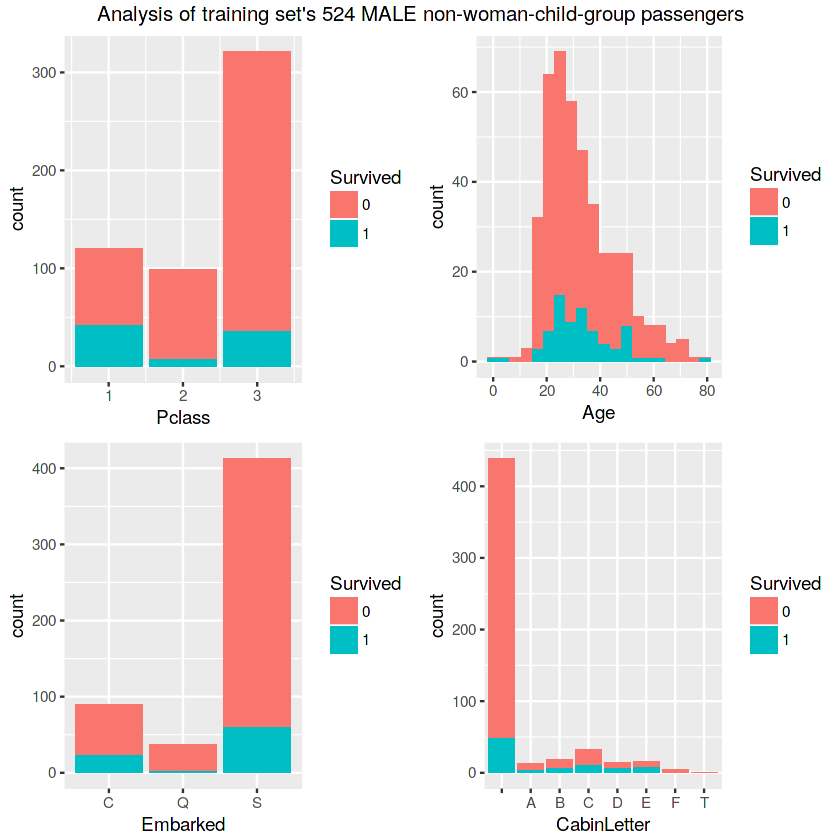

In [9]:
data$GroupId2 = paste( data$Surname, data$Pclass,sub('.$','X',data$Ticket),data$Fare,data$Embarked,sep='-')
for (i in 1:1309){
    if (data$Title[i]=='man' & data$GroupId2[i] %in% x)
    if (data$GroupSurvival[data$GroupId==data$GroupId2[i]][1]==0)
        data$GroupSurvival[i] <- 0
}
x = which(data$Passenger<=891 & data$GroupSurvival!=0 & data$GroupSurvival!=1 & data$Sex=='male')
data2 <- data[x,]
data2$Survived <- factor(data2$Survived)
g1 = ggplot(data=data2) +
    geom_bar(stat='count',aes(x=Pclass,fill=Survived))
g2 = ggplot(data=data2[!is.na(data2$Age),]) +
    geom_histogram(bins=20,aes(x=Age,fill=Survived))
g3 = ggplot(data=data2) +
    geom_bar(stat='count',aes(x=Embarked,fill=Survived))
g4 = ggplot(data=data2) +
    geom_bar(stat='count',aes(x=CabinLetter,fill=Survived))
grid.arrange(g1,g2,g3,g4,nrow=2,top='Analysis of training set\'s 524 MALE non-woman-child-group passengers')

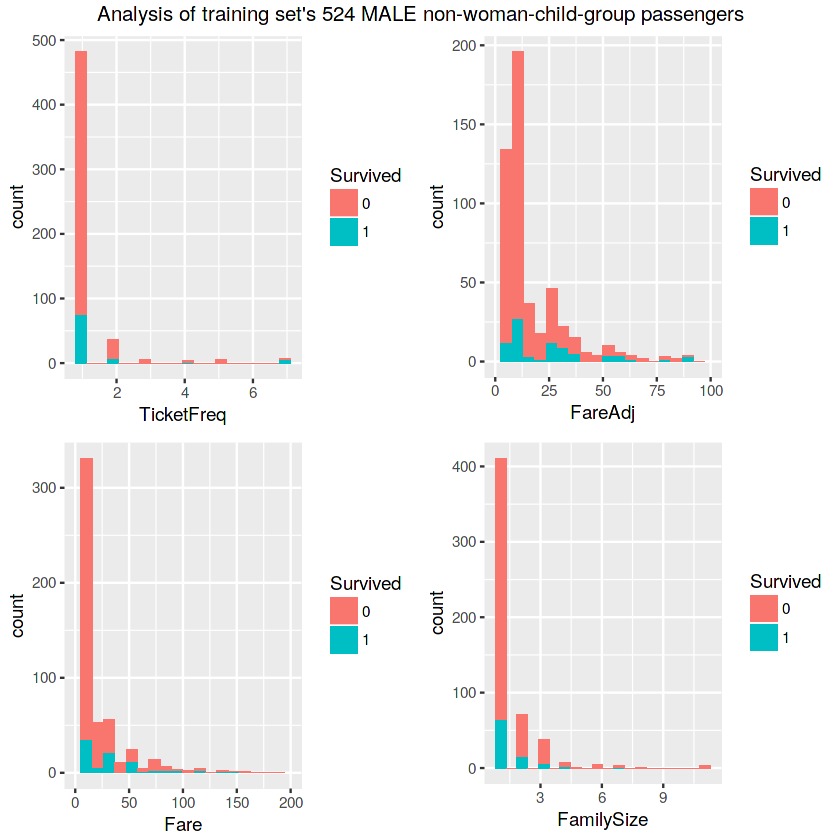

In [10]:
data2$FamilySize <- data2$Parch + data2$SibSp + 1
data2$TicketFreq <- ave(1:nrow(data2),data2$Ticket,FUN=length)
data2$FareAdj <- data2$Fare / data2$TicketFreq
g1 = ggplot(data=data2) +
    geom_histogram(bins=20,aes(x=TicketFreq,fill=Survived))
g2 = ggplot(data=data2) +
    geom_histogram(bins=20,aes(x=FareAdj,fill=Survived),na.rm=T) +
    xlim(0,100)
g3 = ggplot(data=data2) +
    geom_histogram(bins=20,aes(x=Fare,fill=Survived),na.rm=T) +
    xlim(0,200)
g4 = ggplot(data=data2) +
    geom_histogram(bins=20,aes(x=FamilySize,fill=Survived))
grid.arrange(g1,g2,g3,g4,nrow=2,top='Analysis of training set\'s 524 MALE non-woman-child-group passengers')

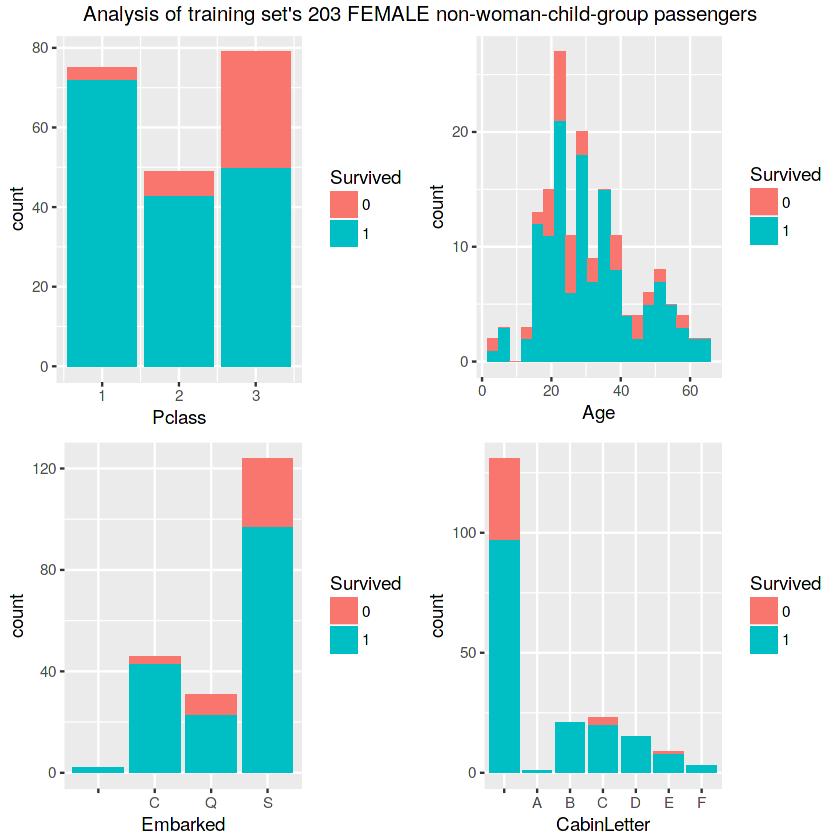

In [11]:
x = which(data$Passenger<=891 & data$GroupSurvival!=0 & data$GroupSurvival!=1 & data$Sex=='female')
data2 <- data[x,]
data2$Survived <- factor(data2$Survived)
g1 = ggplot(data=data2) +
    geom_bar(stat='count',aes(x=Pclass,fill=Survived))
g2 = ggplot(data=data2[!is.na(data2$Age),]) +
    geom_histogram(bins=20,aes(x=Age,fill=Survived))
g3 = ggplot(data=data2) +
    geom_bar(stat='count',aes(x=Embarked,fill=Survived))
g4 = ggplot(data=data2) +
    geom_bar(stat='count',aes(x=CabinLetter,fill=Survived))
grid.arrange(g1,g2,g3,g4,nrow=2,top='Analysis of training set\'s 203 FEMALE non-woman-child-group passengers')

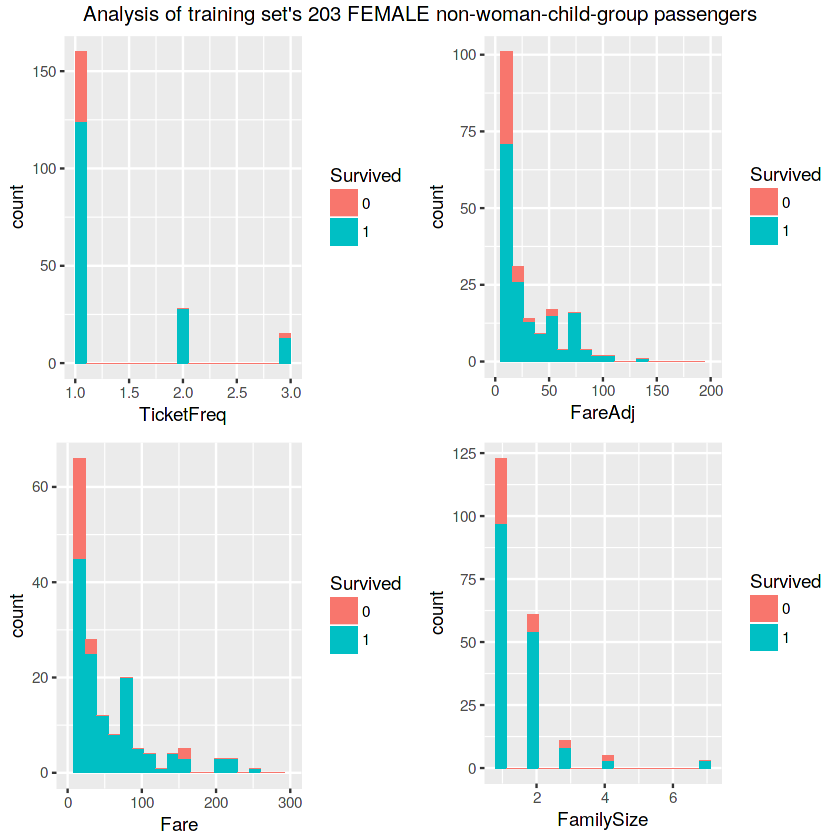

In [12]:
data2$FamilySize <- data2$Parch + data2$SibSp + 1
data2$TicketFreq <- ave(1:nrow(data2),data2$Ticket,FUN=length)
data2$FareAdj <- data2$Fare / data2$TicketFreq
g1 = ggplot(data=data2) +
    geom_histogram(bins=20,aes(x=TicketFreq,fill=Survived))
g2 = ggplot(data=data2) +
    geom_histogram(bins=20,aes(x=FareAdj,fill=Survived),na.rm=T) +
    xlim(0,200)
g3 = ggplot(data=data2) +
    geom_histogram(bins=20,aes(x=Fare,fill=Survived),na.rm=T) +
    xlim(0,300)
g4 = ggplot(data=data2) +
    geom_histogram(bins=20,aes(x=FamilySize,fill=Survived))
grid.arrange(g1,g2,g3,g4,nrow=2,top='Analysis of training set\'s 203 FEMALE non-woman-child-group passengers')

The plots above don't seem to indicate which females perish and which males live. We could engineer more features and do more exploration, but I'm not optimistic that we'll find anything. Tens of thousands of people have been scrutinizing the Titantic dataset for the past 6 years and nobody has scored above 83%. I tried building various models on these 727 training set passengers but so far I haven't been able to increase cross validation accuracy above the gender model. Perhaps the fate of these 727 passengers is completely random.

## B2. Review  the best Kaggle Titanic models

Instead of exploring more now, let's look at the best models submitted to Kaggle and see what those models discovered about the 727 non-woman-child-group passengers.

As of June 1, 2018. Here are the top models in Kaggle's Titanic competition
![leaderboard](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/2020/leaderboard.png)
1. [Konstantin Masich][1] - [Titanic [0.82] - [0.83] ][2]- scores 83.3%
2. [Shao-Chuan Wang][3] - [Titanic: ML tutorial on small dataset - [0.82296]][4] - scores 82.8%
3. [Tae Hyon Whang][5] - [Titanic Starter with XGBoost, 173/209 LB][6] - scores 82.8%
4. [Franck Sylla][7] - [Titanic: Machine Learning from Disaster][8] - scores 82.8%
5. [Chris Deotte][9] - [Titanic using Name only [0.81818]][10] - scores 82.3% (scores 83.3% using all columns)
6. [Oscar Takeshita][11] - [Divide and Conquer [0.82296]][12] - scores 82.3%

(To view a longer list of Titanic models including non conventional ones, see Oscar Takeshita's [post here][13])

[1]:https://www.kaggle.com/konstantinmasich
[2]:https://www.kaggle.com/konstantinmasich/titanic-0-82-0-83/
[3]:https://www.kaggle.com/shaochuanwang
[4]:https://www.kaggle.com/shaochuanwang/titanic-ml-tutorial-on-small-dataset-0-82296/notebook
[5]:https://www.kaggle.com/numbersareuseful
[6]:https://www.kaggle.com/numbersareuseful/titanic-starter-with-xgboost-173-209-lb/notebook
[7]:https://www.kaggle.com/francksylla
[8]:https://www.kaggle.com/francksylla/titanic-machine-learning-from-disaster
[9]:https://www.kaggle.com/cdeotte
[10]:https://www.kaggle.com/cdeotte/titanic-using-name-only-0-81818/notebook
[11]:https://www.kaggle.com/pliptor
[12]:https://www.kaggle.com/pliptor/divide-and-conquer-0-82296/notebook
[13]:https://www.kaggle.com/pliptor/how-am-i-doing-with-my-score

Let's load in the predictions from these models and see which passengers they predict should be changed from the gender model. For example, which females do they predict will die and which males do they predict will live. We are only interested in predictions other than the 22 changes that the woman-child-group model already changed.

In [13]:
top <- read.csv('../input/top-6-titanic-model/top6.csv')
str(top)

'data.frame':	418 obs. of  8 variables:
 $ PassengerId     : int  892 893 894 895 896 897 898 899 900 901 ...
 $ KonstantinMasich: int  0 0 0 0 1 0 1 0 1 0 ...
 $ ShaoChuanWang   : int  0 0 0 0 1 0 1 0 1 0 ...
 $ TaeHyonWhang    : int  0 1 0 0 1 0 1 0 1 0 ...
 $ FranckSylla     : int  0 1 0 0 1 0 1 0 1 0 ...
 $ ChrisDeotte     : int  0 1 0 0 1 0 1 0 1 0 ...
 $ OscarTakeshita  : int  0 0 0 0 1 0 0 0 1 0 ...
 $ GenderModel     : int  0 1 0 0 1 0 1 0 1 0 ...


Above shows the structure of the file. It contains all 418 predictions for the top 6 Titanic models and includes a row with the gender model predictions. Now let's see what predictions everyone agrees on. We will only consider rows 2, 3, 4, 5, 7. Chris Deotte's model (row 6) is the woman-child-group model and says nothing about non-woman-child-group passengers. Let's display which passengers that 3 out of 5 models agree to change from the gender model. The last five columns below indicate how each model voted where 1 = survive and 0 = die.

In [14]:
x = which(data$Passenger>891 & (data$GroupSurvival==0 | data$GroupSurvival==1))
top$Sum <- 0
top$Predict <- top$GenderModel
for (i in 1:418){
    for (j in c(2,3,4,5,7)) top$Sum[i] = top$Sum[i] + top[i,j]
    if (top$GenderModel[i]==0 & top$Sum[i]>2.5) top$Predict[i] <- 1
    if (top$GenderModel[i]==1 & top$Sum[i]<2.5) top$Predict[i] <- 0
}
new <- top$PassengerId[!top$PassengerId %in% x & top$Predict!=top$GenderModel]
data.frame(data[new,c('Name','Pclass','Sex','Age','Fare','Embarked')],KM=top[[2]][new-891]
    ,SCW=top[[3]][new-891],THW=top[[4]][new-891],FS=top[[5]][new-891],OT=top[[7]][new-891])

,Name,Pclass,Sex,Age,Fare,Embarked,KM,SCW,THW,FS,OT
893,"Wilkes, Mrs. James (Ellen Needs)",3,female,47,7.0000,S,0,0,1,1,0
964,"Nieminen, Miss. Manta Josefina",3,female,29,7.9250,S,0,0,1,0,1
978,"Barry, Miss. Julia",3,female,27,7.8792,Q,0,1,1,0,0
1017,"Cribb, Miss. Laura Alice",3,female,17,16.1000,S,0,0,0,1,0
1030,"Drapkin, Miss. Jennie",3,female,23,8.0500,S,0,0,1,0,1
1091,"Rasmussen, Mrs. (Lena Jacobsen Solvang)",3,female,NA,8.1125,S,0,1,1,0,0
1165,"Lennon, Miss. Mary",3,female,NA,15.5000,Q,0,0,0,1,0
1172,"Oreskovic, Miss. Jelka",3,female,23,8.6625,S,0,0,0,0,1
1201,"Hansen, Mrs. Claus Peter (Jennie L Howard)",3,female,45,14.1083,S,0,0,0,1,0
1251,"Lindell, Mrs. Edvard Bengtsson (Elin Gerda Persson)",3,female,30,15.5500,S,0,0,0,1,0


Above are all the passengers that 3 or more of the 5 top models agree to change from the gender model. Only passengers among the 345 test dataset's non-woman-child-groups are showing. Wow, they agree to change 13 passengers! If they are all correct, our score could increase by as much as 3% and hit 86%!!

## B3. Voting Ensemble
Let's build a voting ensemble. We will use the woman-child-group model to predict the 73 test dataset passengers that the woman-child-group model is 97% confident about. (Only 22 of those predictions differ from the gender model.) And we will use a voting ensemble to predict the remaining 345 test dataset passengers. If 3 out of 5 of the top Titanic models vote that a female should die or male should live, we'll predict that. From above, we see that the voting ensemble will predict that 13 females die. And from before, we know that the woman-child-group model will change 22 predictions from the gender model. Therefore we'll be making a total of 35 changes from the gender model.

In [15]:
cat(sprintf('Woman-child-model changes 22 predictions from gender model\n'))
cat(sprintf('Voting ensemble changes %d predictions from gender model\n',length(new)))
submit = data.frame(PassengerId = 892:1309, Survived = top[['GenderModel']])
submit$Survived[x-891] <- data$Predict[x]
submit$Survived[new-891] <- top$Predict[new-891]
write.csv(submit,'MegaModel.csv',row.names=F)

Woman-child-model changes 22 predictions from gender model
Voting ensemble changes 13 predictions from gender model


![result](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/2020/surnameModel4.png)
 
Wow!! We increased our score by 1 percent and achieved 84.2%. It looks like patterns were hiding in the non woman-child-group passengers!

## B4. All Adult Males Die?
There are a few interesting things that we should point out. First, this ensemble model which score 84.2% predicts that all adult males die. Wow, that's incredible. There are 245 adult males in the test dataset, but this ensemble predicts that they all die. The training data set has 538 adult males and 16% = 87 / 538 live. Therefore there are about 39 adult males in the test dataset that should live. Is it possible to correctly predict whether an adult male survives the Titanic? If so, you could combine that model with this Mega Model and score over 84%! Let's see how many males are predicted to live and females to die by each model individually.

In [16]:
p = data.frame(Konstantin=c(0,0,0,0),ShaoChuan=c(0,0,0,0),TaeHyon=c(0,0,0,0),Franck=c(0,0,0,0)
    ,Chris=c(0,0,0,0),Oscar=c(0,0,0,0),GenderModel=c(0,0,0,0))
for (i in 2:8){
    p[[i-1]][1] <- sum(top[[i]][which(data$PassengerId>891 & data$Title=='man')-891])
    p[[i-1]][2] <- 152 - sum(top[[i]][which(data$PassengerId>891 & data$Title=='woman')-891])
    p[[i-1]][3] <- sum(top[[i]][which(data$PassengerId>891 & data$Title=='boy')-891])
    p[[i-1]][4] <- p[[i-1]][1] + p[[i-1]][2] + p[[i-1]][3]
}
row.names(p) <- c('man','female','boy','total'); p

,Konstantin,ShaoChuan,TaeHyon,Franck,Chris,Oscar,GenderModel
man,3,2,4,3,0,5,0
female,29,28,20,23,14,34,0
boy,8,8,9,11,8,8,0
total,40,38,33,37,22,47,0


We see here that these best Kaggle Titanic models don't predict many adult males to live. (They more or less say that they all die.) That's interesting. I would even guess that if these models changed all their adult male predictions to die, then their scores would go up (because below you will see that the 5 top models don't agree on these predictions) Below is a plot showing which males to live and females to die are agreed upon by the ensemble. These are histograms of the cumlative vote score per passenger. The top row are passengers that are already predicted by the woman-child-group model abbreviated WCG. The bottom row show passengers that are not part of woman-child-groups.

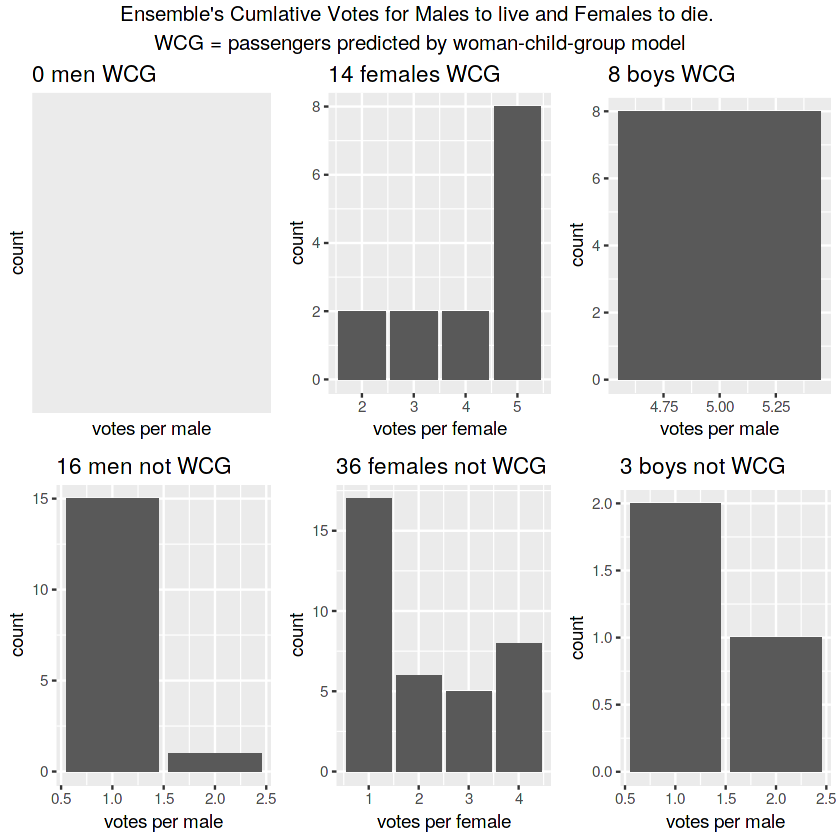

In [17]:
top$Avg <- 0
top$Predict <- top$GenderModel
for (i in 1:418){
    for (j in c(2,3,4,5,7)) top$Avg[i] = top$Avg[i] + top[i,j]
    if (top$GenderModel[i]==0 & top$Avg[i]>0.5) top$Predict[i] <- 1
    if (top$GenderModel[i]==1 & top$Avg[i]<4.5) top$Predict[i] <- 0
}
new <- top$PassengerId[top$Predict!=top$GenderModel]
data2 <- data.frame(data[new,c('Name','PassengerId','Sex','Title')],KM=top[[2]][new-891]
    ,SCW=top[[3]][new-891],THW=top[[4]][new-891],FS=top[[5]][new-891],OT=top[[7]][new-891])
x = which(data$Passenger>891 & ((data$GroupSurvival==0 & data$Sex=='female') | (data$GroupSurvival==1 & data$Sex=='male')) )
data3 <- data2[data2$Title=='man' & data2$PassengerId %in% x,]
data3$votes <- data3$KM + data3$SCW + data3$THW + data3$FS + data3$OT
g1 = ggplot(data=data3) +
    geom_bar( aes(x=votes)) +
    labs(title='0 men WCG',x='votes per male')
data4 <- data2[data2$Title=='woman' & data2$PassengerId %in% x,]
data4$votes <- 5 - (data4$KM + data4$SCW + data4$THW + data4$FS + data4$OT)
g2 = ggplot(data=data4) +
    geom_bar( aes(x=votes)) +
    labs(title='14 females WCG',x='votes per female')
data5 <- data2[data2$Title=='boy' & data2$PassengerId %in% x,]
data5$votes <- data5$KM + data5$SCW + data5$THW + data5$FS + data5$OT
g3 = ggplot(data=data5) +
    geom_bar( aes(x=votes)) +
    labs(title='8 boys WCG',x='votes per male')
data6 <- data2[data2$Title=='man' & !data2$PassengerId %in% x,]
data6$votes <- data6$KM + data6$SCW + data6$THW + data6$FS + data6$OT
g4 = ggplot(data=data6) +
    geom_bar( aes(x=votes)) +
    labs(title='16 men not WCG',x='votes per male')
data7 <- data2[data2$Title=='woman' & !data2$PassengerId %in% x,]
data7$votes <- 5 - (data7$KM + data7$SCW + data7$THW + data7$FS + data7$OT)
g5 = ggplot(data=data7) +
    geom_bar( aes(x=votes)) +
    labs(title='36 females not WCG',x='votes per female')
data8 <- data2[data2$Title=='boy' & !data2$PassengerId %in% x,]
data8$votes <- data8$KM + data8$SCW + data8$THW + data8$FS + data8$OT
g6 = ggplot(data=data8) +
    geom_bar( aes(x=votes)) +
    labs(title='3 boys not WCG',x='votes per male')
grid.arrange(g1,g2,g3,g4,g5,g6,nrow=2,top='Ensemble\'s Cumlative Votes for Males to live and Females to die. 
WCG = passengers predicted by woman-child-group model')

From the top row, we see that all 5 top models predict that the 8 boys in the WCG model should live. Also the 5 top models unanimously agree on 8 females from the WCG to die. Then 4 out of 5 agree on two more females. Then 3 out of 5, and 2 out of 5, agree on the next 2 and next 2. The WCG model predicts that 14 females die. The top row shows that the main reason that the top 5 models have a great score is because they predict 16, 18, 20, or 22 of the winning predictions from the WCG model. This supports the idea that the WCG covers nearly all the predictive power in the best Titanic models.  

The bottom row show that the top 5 models cannot agree on which adult males should live. 15 adult males only get 1 vote each from 1 of the ensemble's models. The top 5 models do agree on some female predictions. 4 out of 5 models agree that 8 particular females die. And 3 out of 5 models agree on 5 females dying. Since the Mega Model has a threshold of 3, those 13 = 8 + 5 females are the only predictions taken from the top 5 models. The Mega Model uses those 13 predictions and the 22 predictions from the WCG.  

## B5. Ensemble performance

Another interesting observation is how the overall ensemble performs better than any model individually or combination of models. I know this is a common data science idea but it's cool to see in action. Here is a table showing scores of different model combinations:  
`Chris + Ensemble = 84.2% (threshold = 3)
Chris + Ensemble = 83.8% (threshold = 4)
Chris + Konstantin = 83.8%
Chris + TaeHyon = 83.8%  
GenderModel + Ensemble = 83.8% (threshold = 3)  
Chris + Ensemble = 83.3% (threshold = 2)
Chris + GenderModel = 83.3%
Chris + ShaoChuan = 82.8%
Chris + Oscar = 82.3%`  
  
This is a neat example of how ensembles help correct errors made by individual models. However, even with self correction, our ensemble only made its 13 predictions with 65% accuracy. (Those 13 predictions increased our score from 83.3% to 84.2% therefore most probably 8.5 were correct and 4.5 were wrong since 1% = (8.5-4.5)/418 ). So there is room for growth in predicting the fates of non-woman-child-group passengers.

## B6. Meet the surviving Wilkes, Hocking, Richards family
After submitting this solution, it was brought to my attention by [Reinhard][1] and [Erik Bruin][3] that I missed a woman-child-group. In both [Reinhard's kernel][2] and [Erik's kernel][4], a meticulous job of identifying all the families aboard the Titanic was done. One thing they used that I forgot was maiden names. They also used SibSp and Parch.

![Wilkes](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/2020/Wilkes.jpeg)

Mrs James Wilkes (Ellen Needs), passenger 893, has a sister as indicated by her SibSp=1 and maiden name. Her sister is Mrs. Elizabeth Hocking (Eliza Needs), passenger 775. Mrs. Hocking has 3 children. Unless you consider her maiden name, you will miss finding her daughter, passenger 438, Mrs. Sidney Richards (Emily Hocking). Mrs Richards has 2 boys, Master George and Master William. Mrs Richards also has 1 sister, Miss Ellen Hocking, and 1 brother Mr. Richard Hocking.  

Mrs. Hocking's husband is not aboard the Titanic. And Mrs Richards' husband is not aboard the Titanic. Everyone's ages are 54, 47, 24, 23, 20, 3, 0.83. This is a group of grand parents, parents, and children traveling together. It is a large woman-child-group consisting of 4 females and 2 boys. This group survives. Therefore the WCG model predicts that the 2 unknown passengers Mrs. Wilkes 893 and Miss Hocking 944 survive. As such, the ensemble can not change the predictions cast by the WCG. Therefore female passenger 893 should be predicted to live.

[1]:https://www.kaggle.com/reisel
[2]:https://www.kaggle.com/reisel/save-the-families/notebook
[3]:https://www.kaggle.com/erikbruin
[4]:https://www.kaggle.com/erikbruin/titanic-2nd-degree-families-and-majority-voting

In [18]:
submit$Survived[893-891] <- 1
write.csv(submit,'MegaModel2.csv',row.names=F)

![result](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/2020/surnameModel5.png)

Thank you for finding this [Reinhard][1] and [Erik Bruin][2]. The Titanic Mega Model now scores 84.7%!! Woohoo!! I reviewed all the other maiden names with SibSp, and Parch. Some families get combined but only one other prediction changes. The WCG should predict that passenger 1251 Mrs. Edvard Lindell dies. She's passenger 252 Mrs Strom's sister linked by the maiden name Persson and Mrs. Strom died. I submitted the updated CSV to Kaggle but the public score stays at 84.7%. Most likely this change increases our private score. Thanks guys.

[1]:https://www.kaggle.com/reisel
[2]:https://www.kaggle.com/erikbruin


# Part C: Conclusion

It was fun to explore the groups aboard the Titanic very precisely and see once again that woman and children were prioritized and they stuck together. We see that the males aboard the Titanic tried hard to rescue all the woman and children before themselves. The woman-child-group model scores 83.3% by itself when it is implemented precisely using all columns of the data. We see that the best models have something to contribute in addition to the woman-child-group model and brought our score up to 84.2%. It would be interesting to study exactly what patterns the other models detect in the data. Perhaps now that we're aware of the strong affect of woman-child-groups, we can remove it from the data and focus on optimizing the other predictors. Perhaps we can build a model with 85% accuracy or better. If anyone does this, please post your discovery as a comment here. Thanks!
 
I was disappointed (and perhaps surprised) that we didn't achieve a higher score. I was thinking that the top 5 Kaggle Titanic models had discovered more patterns in the data besides what woman-child-groups predict. The gender model scores 76.6%, then the woman-child-group model raises that by 6.7% to 83.3%, and so far only another 1% raise has been discovered in the data. In this kernel we saw that the best models more or less predict that all adult males die. This is interesting. The test dataset contains about 40 adult males that survive. If someone could build a model that finds only a few of them, we could combine it with this model and achieve over 85%!!
 
Here's an image from [the forum post][1] that suggested this kernel's strategy. It looks like we are half way between a great job and a fantastic job! There is still room for improvement. If we work together, perhaps we can accomplish a fantastic job! Thanks for reading my notebook and I look forward to your comments. 
 
 ![second](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/2020/second.png)
 
 [1]:https://www.kaggle.com/c/titanic/discussion/57447
 [2]:https://www.kaggle.com/reisel